## Data Analysis

- After Data Analysis we noted that the all images in the dataset didn't have the same shape. So, we plotted the height and width of the images to analyse them 
- After analysis we got these results : 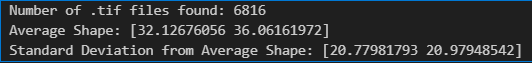

In [90]:
# Importing the required modules
import os
import time
import shutil
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from sklearn.cluster import KMeans
import torch.nn.functional as F
from sklearn.mixture import GaussianMixture

In [40]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Load a sample raster file
with rasterio.open('extracted_files/1_2022_4.tif') as src:
    raster_data = src.read()

# Visualize sample raster
# plt.imshow(raster_data)
# plt.colorbar()
# plt.show()

# Explore raster data properties
print("Raster shape:", raster_data.shape)
print("Raster dtype:", raster_data.dtype)
print("Raster unique values:", np.unique(raster_data))


Raster shape: (4, 34, 14)
Raster dtype: uint8
Raster unique values: [  0  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  93  94  95  96  97
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 116 117
 118 120 121 123 129 255]


## Folder Structure : extracted_files->.tif files

Number of .tif files found: 6816
Average Shape: [32.12676056 36.06161972]
Standard Deviation from Average Shape: [20.77981793 20.97948542]


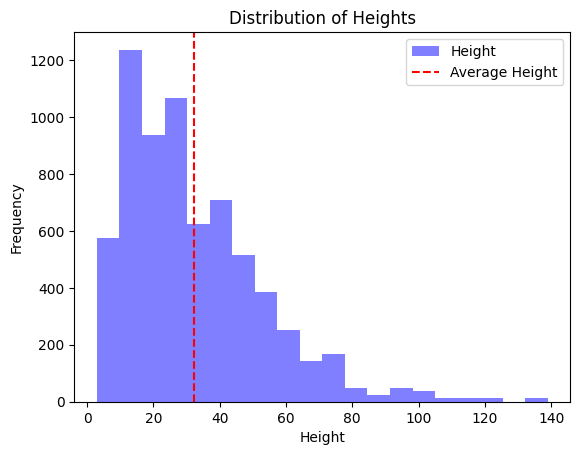

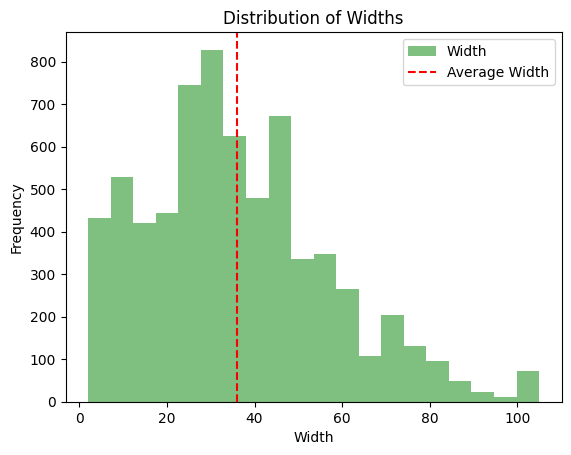

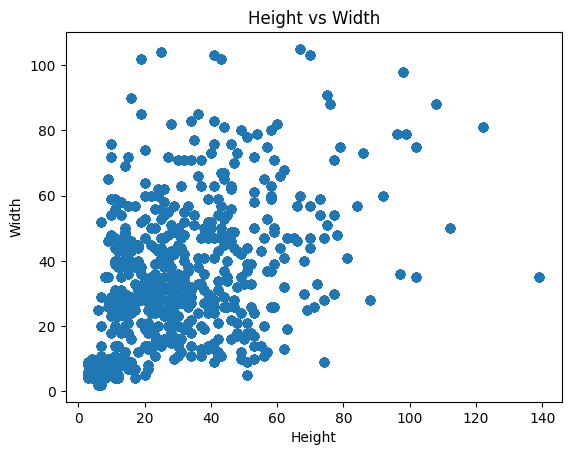

In [41]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Function to get shapes of all .tif files
def get_tif_shapes(tif_files):
    shapes = []
    for file in tif_files:
        with rasterio.open(file) as src:
            shapes.append(src.shape)
    return shapes

# Function to plot histograms and graphs
def plot_histograms_and_graphs(shapes, average_shape, std_shape):
    # Plot histogram of heights
    plt.hist([shape[0] for shape in shapes], bins=20, alpha=0.5, color='b', label='Height')
    plt.axvline(x=average_shape[0], color='r', linestyle='--', label='Average Height')
    plt.xlabel('Height')
    plt.ylabel('Frequency')
    plt.title('Distribution of Heights')
    plt.legend()
    plt.show()

    # Plot histogram of widths
    plt.hist([shape[1] for shape in shapes], bins=20, alpha=0.5, color='g', label='Width')
    plt.axvline(x=average_shape[1], color='r', linestyle='--', label='Average Width')
    plt.xlabel('Width')
    plt.ylabel('Frequency')
    plt.title('Distribution of Widths')
    plt.legend()
    plt.show()

    # Plot scatter plot of height vs width
    plt.scatter([shape[0] for shape in shapes], [shape[1] for shape in shapes])
    plt.xlabel('Height')
    plt.ylabel('Width')
    plt.title('Height vs Width')
    plt.show()
    
    shapescopy = shapes

# Main function
def main(extracted_folder):
    # List all .tif files
    tif_files = [os.path.join(extracted_folder, f) for f in os.listdir(extracted_folder) if f.endswith('.tif')]
    print("Number of .tif files found:", len(tif_files))
    
    # Get shapes of all .tif files
    shapes = get_tif_shapes(tif_files)
    
    # Calculate average shape and standard deviation
    average_shape = np.mean(shapes, axis=0)
    std_shape = np.std(shapes, axis=0)
    
    # Print average shape and standard deviation
    print("Average Shape:", average_shape)
    print("Standard Deviation from Average Shape:", std_shape)
    
    # Plot histograms and graphs
    plot_histograms_and_graphs(shapes, average_shape, std_shape)

# Define path to the extracted folder
extracted_folder = 'extracted_files'

# Call the main function
main(extracted_folder)


## Preprocessing


In [63]:
folder_path = 'extracted_files'


target_size = (36, 36)
transform = transforms.Compose([
    transforms.CenterCrop(target_size),
    transforms.Resize(target_size),
    transforms.ToTensor(),
])

tensor_images = []

name = []


final_folder_path = folder_path 
for filename in os.listdir(final_folder_path):
    if filename.endswith('.tif'):
        image_path = os.path.join(final_folder_path, filename)

        try:
          image = Image.open(image_path)
        except:
          continue

        tensor_image = transform(image)

        name.append(filename)

        tensor_images.append(tensor_image)

In [64]:
len(tensor_images)

6816

## Model for Clustering Images

In [65]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :36, :36]

size_temp = 4*36*36


class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
                nn.Conv2d(4, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),
        )

        self.z_mean = torch.nn.Linear(size_temp, 2)
        self.z_log_var = torch.nn.Linear(size_temp, 2)

        self.decoder = nn.Sequential(
                torch.nn.Linear(2, size_temp),
                Reshape(-1, 64, 9, 9),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 4, stride=(1, 1), kernel_size=(3, 3), padding=0),
                Trim(),  # 1x161x225 -> 1x160x224
                nn.Sigmoid()
                )

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded

    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.device)
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z

    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [66]:
checkpoints = "checkpoints"

# Training function
def train_vae_v1(num_epochs, model, optimizer, device,
                 train_loader, loss_fn=None,
                 logging_interval=100,
                 reconstruction_term_weight=1,
                 save_model=None):

    log_dict = {'train_combined_loss_per_batch': [],
                'train_combined_loss_per_epoch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': []}

    if loss_fn is None:
        loss_fn = F.mse_loss

    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):

            features = features.to(device)

            # FORWARD AND BACK PROP
            encoded, z_mean, z_log_var, decoded = model(features)

            kl_div = -0.5 * torch.sum(1 + z_log_var
                                      - z_mean**2
                                      - torch.exp(z_log_var),
                                      axis=1) # sum over latent dimension

            batchsize = kl_div.size(0)
            kl_div = kl_div.mean() # average over batch dimension

            pixelwise = loss_fn(decoded, features, reduction='none')
            pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
            pixelwise = pixelwise.mean() # average over batch dimension

            loss = reconstruction_term_weight*pixelwise + kl_div

            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            log_dict['train_combined_loss_per_batch'].append(loss.item())
            log_dict['train_reconstruction_loss_per_batch'].append(pixelwise.item())
            log_dict['train_kl_loss_per_batch'].append(kl_div.item())

            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    if save_model is not None:
        save_modeltemp = os.path.join(checkpoints, save_model)
        save_modeltemp  = save_modeltemp + ".pth"
        torch.save(model.state_dict(), save_modeltemp)

    return encoded, decoded

In [67]:
# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Getting data loader for the given dataset
basic_images = torch.tensor([list(i.numpy()) for i in tensor_images])
train_dataset = TensorDataset(basic_images, basic_images)
train_loader = DataLoader(dataset=train_dataset, batch_size=256, num_workers=2, shuffle=False)


# Initialize VAE model and optimizer
vae_model = VAE()
optimizer = optim.Adam(vae_model.parameters(), lr=1e-4)

# Using pretrained weights
ckpt = os.path.join(checkpoints, 'ckpt1.pth')
vae_model.load_state_dict(torch.load(ckpt, map_location=torch.device('cpu')))

Device: cpu


<All keys matched successfully>

In [ ]:
# training the model
encoded, decoded = train_vae_v1(1000, vae_model, optimizer, DEVICE,
                 train_loader, loss_fn=None,
                 save_model= "ckpt1",
                 logging_interval=10)

In [68]:
X_list = [] # List to store all the encoded inputs i.e. All the latent vector of VAE

In [69]:
# Appending all the encoded inputs and storing them in X_list i.e. All the latent vector of VAE
for batch_idx, (features, _) in enumerate(train_loader):
  encoded, z_mean, z_log_var, decoded = vae_model(features)
  df = pd.DataFrame(encoded.cpu().detach().numpy())
  x = df.iloc[:, :].values
  for i in x:
    X_list.append(i)

In [70]:
len(X_list)

6816

In [71]:
# Showing a particular image present at a particular index
def showimg(i, datalist):
  plt.imshow(datalist[i][0, :,:])
  return

# Kmean clustering implementation
def kmean_clusters(n_cluster, X):
  kmeans = KMeans(n_clusters = n_cluster, init = 'k-means++')
  y_kmeans = kmeans.fit_predict(X)
  return y_kmeans

# Gaussian mixture model for clustering
def gaussian_mixture_cluster(n_cluster, X):
  gmm = GaussianMixture(n_components=n_cluster)
  gmm.fit(X)
  labels = gmm.predict(X)
  return labels

In [72]:
X = np.array(X_list) # List to numpy array

In [73]:
len(X)

6816

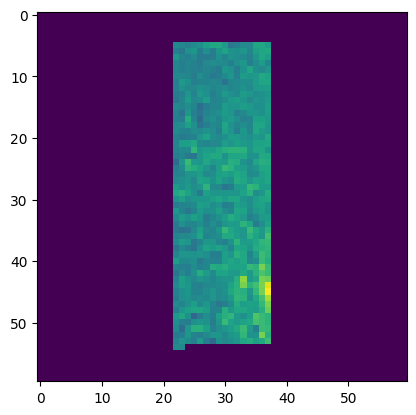

In [74]:
showimg(30, tensor_images)

In [75]:
total_groups = 3
# Applying Gaussian mixture model
labels = gaussian_mixture_cluster(total_groups, X)

In [76]:
# Showing output as dataframe
groups = pd.DataFrame(columns=["Groups", "name"])
groups.iloc[:, 0] = list(labels)
groups.iloc[:, 1] = name

In [ ]:
pd.options.display.max_rows = 10000
groups

In [80]:
grps = {} # Dictionary to store images in their group i.e. KEY-group no, VALUE-images
for i in range(len(groups.iloc[:, 0])):
  key = groups.iloc[i, 0]
  if key not in grps:
    grps[key] = []
  grps[key].append(groups.iloc[i ,1])


target_size = (60, 60)
newtransform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
])

def newimshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Helper function to show the image of a particular group
def group_wise_image(group_no, show_img = 1):
  lst = grps[group_no]

  tensor_images_for_groups = []
  name = []

  folder_path = 'extracted_files'

  for filename in os.listdir(folder_path):
    if filename not in lst:
      continue
    if filename.endswith('.tif'):
        image_path = os.path.join(folder_path, filename)
        image = Image.open(image_path)
        tensor_image = newtransform(image)
        tensor_images_for_groups.append(tensor_image)
        name.append(filename)

  if show_img == 1 :
    newimshow(torchvision.utils.make_grid(tensor_images_for_groups))
  return name

# Function to store images in their group
def group_wise_image_saved():
  grp_folder_path = 'group_wise_data'
  if os.path.exists(grp_folder_path):
    shutil.rmtree(grp_folder_path)
  os.makedirs(grp_folder_path, exist_ok=True)
  folder_path = 'extracted_files'
  for i in range(total_groups):
      names = group_wise_image(i, 0)
      new_folder_name = f'class_{i}'
      new_folder_path = os.path.join(grp_folder_path, new_folder_name)
      os.makedirs(new_folder_path, exist_ok=True)
      for name in names:
        image_path = os.path.join(folder_path, name)
        image = Image.open(image_path)
        full_path = os.path.join(new_folder_path, name)
        image.save(full_path)
  return

# Function to count number of images in a particular group
def count_images_in_classes():
  for i in range(total_groups):
    print(f"Number of images in class_{i} is {len(group_wise_image(i, 0))}")
  return

In [81]:
group_wise_image_saved()

In [82]:
count_images_in_classes()

Number of images in class_0 is 1720
Number of images in class_1 is 3580
Number of images in class_2 is 1516


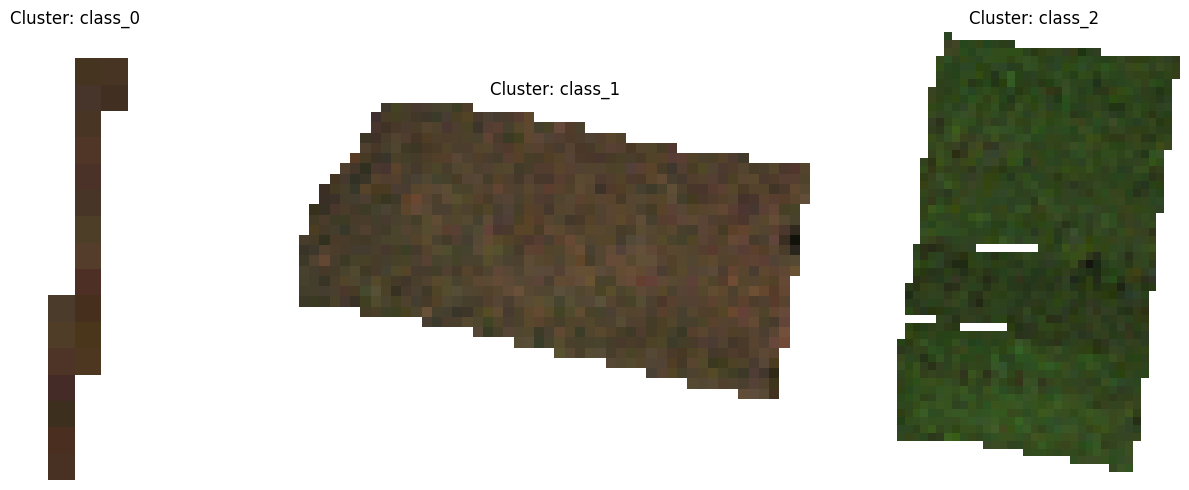

In [89]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the folder containing the image clusters
folder_path = "group_wise_data"


cluster_folders = os.listdir(folder_path)


fig, axs = plt.subplots(1, len(cluster_folders), figsize=(15, 5))


for i, cluster_folder in enumerate(cluster_folders):
   
    cluster_folder_path = os.path.join(folder_path, cluster_folder)
    
    
    if os.path.isdir(cluster_folder_path):
        
        images = os.listdir(cluster_folder_path)
        
        
        if images:
           
            random_image = random.choice(images)
            
            
            image_path = os.path.join(cluster_folder_path, random_image)
            
            
            img = mpimg.imread(image_path)
            axs[i].imshow(img)
            axs[i].set_title(f"Cluster: {cluster_folder}")
            axs[i].axis('off')
            
    
           
        else:
            print(f"No images found in {cluster_folder}.")
    else:
        print(f"{cluster_folder} is not a directory.")


plt.tight_layout()
plt.show()
